In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:

import re
import json
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, classification_report, confusion_matrix

In [6]:
# Paths for Kaggle dataset
FAKE_PATH = "/kaggle/input/fake-and-real-news-dataset/Fake.csv"
TRUE_PATH = "/kaggle/input/fake-and-real-news-dataset/True.csv"

In [7]:
def basic_clean(text: str) -> str:
    text = text.replace("\n", " ").replace("\t", " ")
    text = re.sub(r"http\S+|www\.\S+", " URL ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [8]:
# Load ISOT
fake = pd.read_csv(FAKE_PATH)
true = pd.read_csv(TRUE_PATH)

In [9]:
# Label: fake=1, real=0
fake["label"] = 1
true["label"] = 0

In [10]:
# Concatenate datasets
df = pd.concat([fake, true], ignore_index=True)

In [11]:
# Concatenate title + text
if "text" in df.columns and "title" in df.columns:
    X = (df["title"].fillna("") + " " + df["text"].fillna("")).astype(str)
elif "text" in df.columns:
    X = df["text"].fillna("").astype(str)
else:
    # Fallback if columns differ
    raise ValueError(f"Expected 'title' and/or 'text' columns, found: {list(df.columns)}")

y = df["label"].astype(int).values

In [12]:
# Light cleaning
X = X.apply(basic_clean)

In [13]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [14]:
# Build pipeline
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2),
        min_df=2,
        max_df=0.9,
        max_features=100000,
        lowercase=True,
        strip_accents="unicode",
        stop_words="english"
    )),
    ("logreg", LogisticRegression(
        C=2.0,
        class_weight="balanced",
        penalty="l2",
        solver="liblinear",
        max_iter=1000
    ))
])

In [15]:
# CV on training set
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="f1")
print(f"CV F1 scores: {cv_scores} | Mean: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

CV F1 scores: [0.99106786 0.99078649 0.99199573 0.98877905 0.99011488] | Mean: 0.9905 ± 0.0011


In [16]:
# Train
pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, max_features=100000, min_df=2,
                                 ngram_range=(1, 2), stop_words='english',
                                 strip_accents='unicode')),
                ('logreg',
                 LogisticRegression(C=2.0, class_weight='balanced',
                                    max_iter=1000, solver='liblinear'))])

In [17]:
# Evaluate
y_pred = pipe.predict(X_test)

In [18]:
# Probability for positive class if available
if hasattr(pipe.named_steps["logreg"], "predict_proba"):
    y_prob = pipe.predict_proba(X_test)[:, 1]
else:
    decision = pipe.decision_function(X_test)
    y_prob = (decision - decision.min()) / (decision.max() - decision.min() + 1e-12)

acc = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary", zero_division=0)
try:
    auc = roc_auc_score(y_test, y_prob)
except Exception:
    auc = float("nan")
cm = confusion_matrix(y_test, y_pred)

In [19]:
print("\nMetrics:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1:        {f1:.4f}")
print(f"ROC-AUC:   {auc:.4f}")
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))


Metrics:
Accuracy:  0.9922
Precision: 0.9942
Recall:    0.9908
F1:        0.9925
ROC-AUC:   0.9996

Confusion Matrix:
 [[4257   27]
 [  43 4653]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      4284
           1       0.99      0.99      0.99      4696

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
plt.style.use("seaborn-v0_8-whitegrid")  # clean look


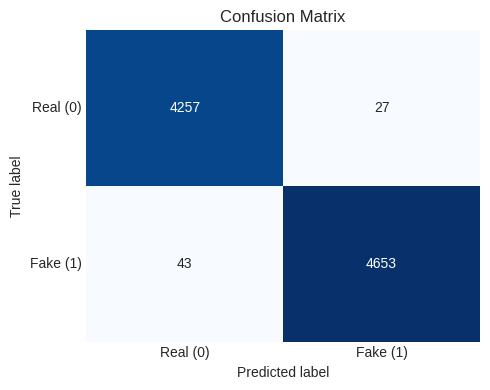

In [21]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_xticklabels(["Real (0)", "Fake (1)"])
ax.set_yticklabels(["Real (0)", "Fake (1)"], rotation=0)
plt.tight_layout()
plt.show()


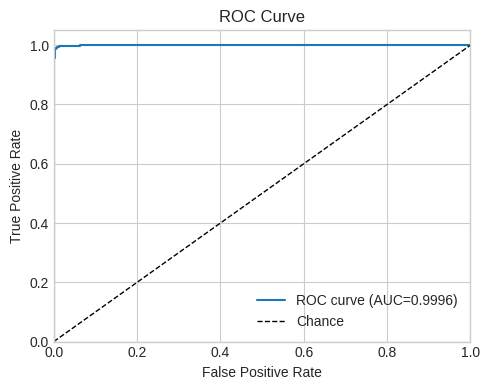

In [22]:
from sklearn.metrics import auc, roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(5,4))
ax.plot(fpr, tpr, label=f"ROC curve (AUC={roc_auc:.4f})")
ax.plot([0,1], [0,1], "k--", lw=1, label="Chance")
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve")
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()


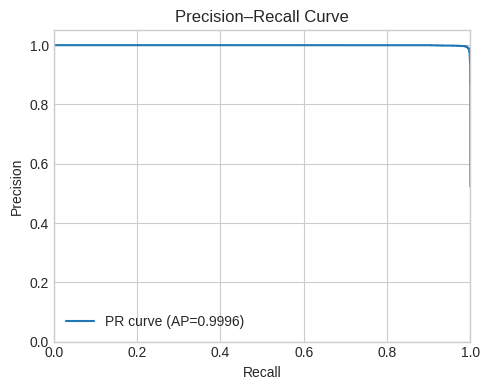

In [23]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision_vals, recall_vals, pr_thresholds = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)

fig, ax = plt.subplots(figsize=(5,4))
ax.plot(recall_vals, precision_vals, label=f"PR curve (AP={ap:.4f})")
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision–Recall Curve")
ax.legend(loc="lower left")
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


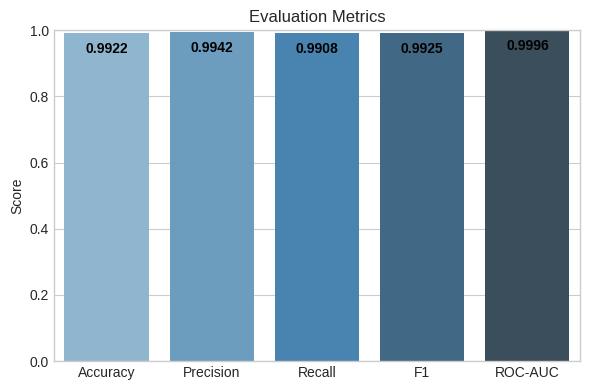

In [24]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary", zero_division=0)
auc_val = roc_auc_score(y_test, y_prob)

metrics_dict = {
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1": f1,
    "ROC-AUC": auc_val
}

fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(x=list(metrics_dict.keys()), y=list(metrics_dict.values()), ax=ax, palette="Blues_d")
ax.set_ylim(0.0, 1.0)
for i, v in enumerate(metrics_dict.values()):
    ax.text(i, v + 0.02 if v < 0.95 else v - 0.06, f"{v:.4f}", ha="center", color="black", fontweight="bold")
ax.set_title("Evaluation Metrics")
ax.set_ylabel("Score")
plt.tight_layout()
plt.show()


,threshold,precision,recall,f1
0,0.1,0.890871,0.999574,0.942097
1,0.2,0.960861,0.998509,0.979323
2,0.3,0.980741,0.997658,0.989127
3,0.4,0.987547,0.996380,0.991944
4,0.5,0.994231,0.990843,0.992534
5,0.6,0.996977,0.983177,0.990029
6,0.7,0.998237,0.964864,0.981267
7,0.8,0.998636,0.935690,0.966139
8,0.9,1.000000,0.855835,0.922318


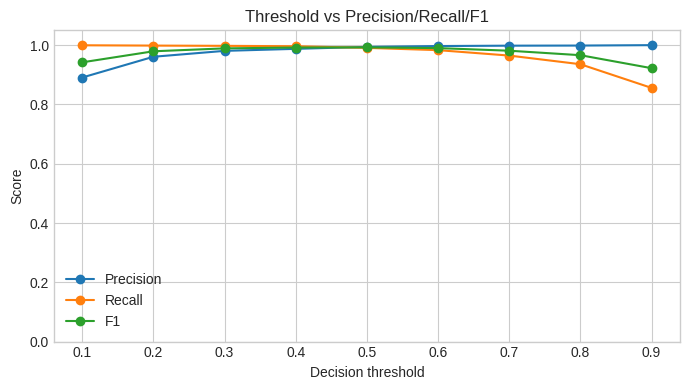

In [25]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds_to_try = np.linspace(0.1, 0.9, 9)
rows = []
for thr in thresholds_to_try:
    preds_thr = (y_prob >= thr).astype(int)
    rows.append({
        "threshold": thr,
        "precision": precision_score(y_test, preds_thr, zero_division=0),
        "recall": recall_score(y_test, preds_thr, zero_division=0),
        "f1": f1_score(y_test, preds_thr, zero_division=0)
    })

thr_df = pd.DataFrame(rows)
display(thr_df)

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(thr_df["threshold"], thr_df["precision"], marker="o", label="Precision")
ax.plot(thr_df["threshold"], thr_df["recall"], marker="o", label="Recall")
ax.plot(thr_df["threshold"], thr_df["f1"], marker="o", label="F1")
ax.set_xlabel("Decision threshold")
ax.set_ylabel("Score")
ax.set_title("Threshold vs Precision/Recall/F1")
ax.set_ylim(0.0, 1.05)
ax.legend()
plt.tight_layout()
plt.show()
